In [1670]:
#import train data using pandas
#key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count

import pandas as pd
import numpy as np
from pyproj import Geod
from scipy import stats
import seaborn
import matplotlib.pyplot as plt
import math
from math import sqrt
from scipy.stats import zscore
from sklearn import preprocessing
import os
import csv

taxi_train_df = pd.read_csv('train.csv',  error_bad_lines=False, usecols=range(1,8))
print("Loaded %d rows" % len(taxi_train_df))

Loaded 55423856 rows


In [1671]:
#Task 1 clean the data

num_cols = ['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']
date_cols = ['pickup_datetime']

#filter out rows where numerical values are not numerical
taxi_train_df[num_cols] = taxi_train_df[num_cols].apply(pd.to_numeric, errors='coerce').astype(np.float32)

#filter out invalid dates
taxi_train_df[date_cols] = taxi_train_df[date_cols].apply(pd.to_datetime, errors='coerce')

#filter out latitides==0 or longitudes=0
taxi_train_df.loc[(taxi_train_df['pickup_longitude']==0) | (taxi_train_df['pickup_latitude']==0) | (taxi_train_df['dropoff_longitude']==0) | (taxi_train_df['dropoff_latitude']==0), 'pickup_longitude'] = np.nan
taxi_train_df.loc[(taxi_train_df['passenger_count']>6) | (taxi_train_df['passenger_count']<1), 'passenger_count'] = np.nan
taxi_train_df.loc[taxi_train_df['fare_amount']<2, 'fare_amount'] = np.nan

#drop NaN values
taxi_train_df = taxi_train_df.dropna()

print(taxi_train_df.dtypes)

print(len(taxi_train_df))
print(taxi_train_df.values[0])


fare_amount                 float32
pickup_datetime      datetime64[ns]
pickup_longitude            float32
pickup_latitude             float32
dropoff_longitude           float32
dropoff_latitude            float32
passenger_count             float32
dtype: object
54124080
[4.5 Timestamp('2009-06-15 17:26:21') -73.84431457519531
 40.721317291259766 -73.84161376953125 40.712276458740234 1.0]


In [1672]:
wgs84_geod = Geod(ellps='WGS84')

#get euclidean distance between 2 lat long points
def get_euclidean_distance(row):
    try:
        az12,az21,dist = wgs84_geod.inv(row['pickup_longitude'],row['pickup_latitude'],row['dropoff_longitude'],row['dropoff_latitude'])
        return dist
    except:
        return 0

#get manhattan distance between 2 lat long points
def get_manhattan_distance(row):
    y = abs(row['pickup_longitude']-row['dropoff_longitude']) 
    x = abs(row['pickup_latitude']-row['dropoff_latitude'])
    if(x==0 or y==0):
        return row['euclidean_dist'] 
    z=y/x;
    x = row['euclidean_dist']/sqrt(1+(z*z))
    return (x+z*x)*(0.621371)
    

#get hour and minute distance between 2 lat long points
def get_hour_minute(row):
    return int(row['pickup_datetime'].hour)*100 + int(row['pickup_datetime'].minute)

def get_date_month(row):
    return int(row['pickup_datetime'].month)*100 + int(row['pickup_datetime'].day)

def get_fare_per_km(row):
     return (row['fare_amount']*1000)/row['manhattan_dist']

def get_year_month(row):
    return int(row['pickup_datetime'].year)*100 + int(row['pickup_datetime'].month)

def get_time_slot(row):
    return int(row['time_of_day']/100)

def get_day_of_week(row):
    return row['pickup_datetime'].weekday()

def add_set1_features(taxi_train_df):
    taxi_train_df['euclidean_dist'] = taxi_train_df.apply (lambda row: get_euclidean_distance(row),axis=1)
    taxi_train_df['manhattan_dist'] = taxi_train_df.apply (lambda row: get_manhattan_distance(row),axis=1)
    taxi_train_df['time_of_day'] = taxi_train_df.apply (lambda row: get_hour_minute(row),axis=1)
    taxi_train_df['day_of_year'] = taxi_train_df.apply (lambda row: get_date_month(row),axis=1)

def add_set2_features(taxi_train_df):
    taxi_train_df['month_of_year'] = taxi_train_df.apply (lambda row: get_year_month(row),axis=1)
    taxi_train_df['time_slot'] = taxi_train_df.apply (lambda row: get_time_slot(row),axis=1)
    taxi_train_df['day_of_week'] = taxi_train_df.apply (lambda row: get_day_of_week(row),axis=1)
    taxi_train_df['passenger_count'] = taxi_train_df['passenger_count']/5
    taxi_train_df.loc[taxi_train_df['passenger_count']<1, 'passenger_count'] = 0
    taxi_train_df.loc[taxi_train_df['passenger_count']>1, 'passenger_count'] = 1
    print(taxi_train_df.values[0])
    
add_set1_features(taxi_train_df) 

taxi_train_df.loc[taxi_train_df['euclidean_dist']==0, 'euclidean_dist'] = np.nan
taxi_train_df = taxi_train_df.dropna()

taxi_train_df['fare_per_km'] = taxi_train_df.apply (lambda row: get_fare_per_km(row),axis=1)
add_set2_features(taxi_train_df)

taxi_train_df.loc[(taxi_train_df['fare_per_km']>10), 'fare_per_km'] = np.nan
taxi_train_df.loc[taxi_train_df['fare_per_km']<0.3, 'fare_per_km'] = np.nan

taxi_train_df.loc[(taxi_train_df['pickup_longitude']>-73.6) | (taxi_train_df['pickup_longitude']<-74.1) | (taxi_train_df['pickup_latitude']<40.58) | (taxi_train_df['pickup_latitude']>41), 'pickup_longitude'] = np.nan
taxi_train_df.loc[(taxi_train_df['dropoff_longitude']>-72.5) | (taxi_train_df['dropoff_longitude']<-75) | (taxi_train_df['dropoff_latitude']>42) | (taxi_train_df['dropoff_latitude']<40), 'dropoff_longitude'] = np.nan


taxi_train_df = taxi_train_df.dropna()


[4.5 Timestamp('2009-06-15 17:26:21') -73.84431457519531
 40.721317291259766 -73.84161376953125 40.712276458740234 0.0
 1029.578969039803 796.1019754232934 1726 615 5.652542185449692 200906 17
 0]


In [1673]:
#Task 2.1
print("Pearson correlation between fare amount and euclidean distance: %f" % stats.pearsonr(taxi_train_df.fare_amount, taxi_train_df.euclidean_dist)[0])

#Task 2.2
print("Pearson correlation between time of day and distance travelled: %f" % stats.pearsonr(taxi_train_df.time_of_day, taxi_train_df.manhattan_dist)[0])

#Task 2.3
print("Pearson correlation between fare amount and manhattan distance: %f" % stats.pearsonr(taxi_train_df.time_of_day, taxi_train_df.fare_amount)[0])


Pearson correlation between fare amount and euclidean distance: 0.923611
Pearson correlation between time of day and distance travelled: -0.031132
Pearson correlation between fare amount and manhattan distance: -0.018332


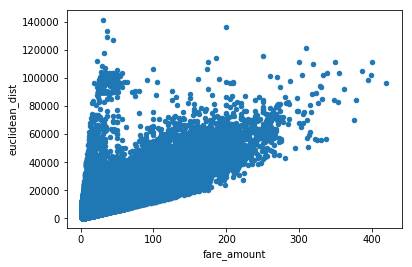

In [1674]:
#Task 3.1.1 Plot between taxi fare and distance travelled
plot = taxi_train_df.plot.scatter('fare_amount', 'euclidean_dist')

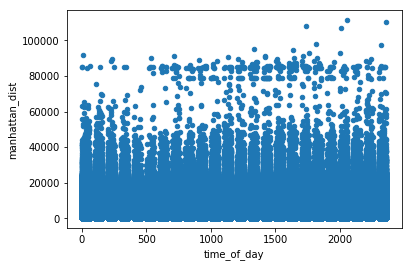

In [1675]:
#Task 3.2.1 Plot between time of day and distance travelled
plot = taxi_train_df.plot.scatter('time_of_day', 'manhattan_dist')

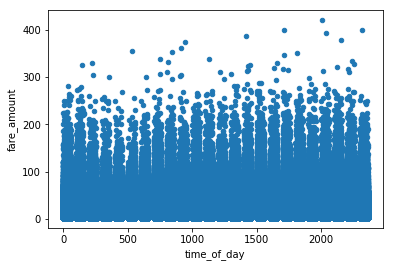

In [1676]:
#Task 3.3.1 Plot between time of day and distance travelled
plot = taxi_train_df.plot.scatter('time_of_day', 'fare_amount')

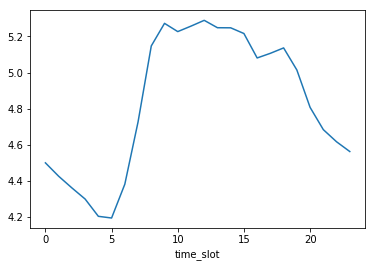

In [1677]:
#Task 4
taxi_train_df.groupby('time_slot')['fare_per_km'].aggregate('mean').plot()

In [1678]:
#taxi_train_df.groupby('time_slot')['fare_per_km'].aggregate('mean')
#taxi_train_df[(taxi_train_df["time_slot"] >14) & (taxi_train_df["time_slot"] < 20)].groupby('day_of_week')['fare_per_km'].aggregate('mean')


In [1679]:
#baseline model with Linear Regression.

def get_input_matrix(taxi_train_df):
    return np.column_stack((taxi_train_df.manhattan_dist, np.ones(len(taxi_train_df))))

features_cols = get_input_matrix(taxi_train_df)
predict_cols =  np.array(taxi_train_df['fare_amount'])

(coefficient_weight, _, _, _) = np.linalg.lstsq(features_cols, predict_cols, rcond = None)
print(coefficient_weight)

test_data_df = pd.read_csv('test.csv')
test_data_df[date_cols] = test_data_df[date_cols].apply(pd.to_datetime, errors='coerce')

add_set1_features(test_data_df)
add_set2_features(test_data_df)

test_X = get_input_matrix(test_data_df)
test_y_predictions = np.matmul(test_X, coefficient_weight).round(decimals = 2)

submission = pd.DataFrame(
    {'key': test_data_df.key, 'fare_amount': test_y_predictions},
    columns = ['key', 'fare_amount'])
submission.to_csv('prediction-baseline.csv', index = False)



[2.87665353e-03 3.25342081e+00]
['2015-01-27 13:08:24.0000002' Timestamp('2015-01-27 13:08:24')
 -73.97332000732422 40.7638053894043 -73.98143005371094 40.74383544921875
 0.0 2320.9910982709694 1878.8630821034126 1308 127 201501 13 1]


In [1680]:
#model with extra features like time slot and day of week

def get_input_matrix(taxi_train_df):
    return np.column_stack((taxi_train_df.manhattan_dist, taxi_train_df.time_slot, taxi_train_df.day_of_week))

features_cols = get_input_matrix(taxi_train_df)
predict_cols =  np.array(taxi_train_df['fare_amount'])
            
(coefficient_weight, _, _, _) = np.linalg.lstsq(features_cols, predict_cols, rcond = None)
print(coefficient_weight)

test_data_df = pd.read_csv('test.csv')
test_data_df[date_cols] = test_data_df[date_cols].apply(pd.to_datetime, errors='coerce')

add_set1_features(test_data_df)
add_set2_features(test_data_df)

test_X = get_input_matrix(test_data_df)
test_y_predictions = np.matmul(test_X, coefficient_weight).round(decimals = 2)

submission = pd.DataFrame(
    {'key': test_data_df.key, 'fare_amount': test_y_predictions},
    columns = ['key', 'fare_amount'])
submission.to_csv('prediction-with-extra-features.csv', index = False)

[0.00299476 0.13128222 0.26114069]
['2015-01-27 13:08:24.0000002' Timestamp('2015-01-27 13:08:24')
 -73.97332000732422 40.7638053894043 -73.98143005371094 40.74383544921875
 0.0 2320.9910982709694 1878.8630821034126 1308 127 201501 13 1]


In [1681]:
#get inflation data for last 10 years
#source of data: https://data.bls.gov/timeseries/CUUR0000SA0 

def get_inflation_data(file):
    with open(file, mode='r') as f:
        reader = csv.reader(f)
        return {rows[0]:rows[1] for rows in reader}

cpi_inflation = get_inflation_data('inflation-data.csv')

def get_inflation_adjusted_price(row):
    return (row['fare_amount']*float(cpi_inflation['201808']))/float(cpi_inflation[str(int(row['month_of_year']))])
    
taxi_train_df['inflation_adjusted_fare'] = taxi_train_df.apply (lambda row: get_inflation_adjusted_price(row),axis=1)


In [1682]:
#model with extra features like time slot and inflation adjustment

def get_input_matrix(taxi_train_df):
    return np.column_stack((taxi_train_df.manhattan_dist, taxi_train_df.time_slot, np.ones(len(taxi_train_df))))


features_cols = get_input_matrix(taxi_train_df)
predict_cols =  np.array(taxi_train_df['inflation_adjusted_fare'])

(coefficient_weight, _, _, _) = np.linalg.lstsq(features_cols, predict_cols, rcond = None)
print(coefficient_weight)


[3.17716592e-03 1.56638555e-02 3.43352248e+00]


In [1683]:
test_data_df = pd.read_csv('test.csv')


test_data_df[date_cols] = test_data_df[date_cols].apply(pd.to_datetime, errors='coerce')

add_set1_features(test_data_df)
add_set2_features(test_data_df)

test_X = get_input_matrix(test_data_df)
test_y_predictions = np.matmul(test_X, coefficient_weight).round(decimals = 2)

def get_deflated_data(df, predictions):
    for i in range(0, len(predictions)):
        predictions[i] = (predictions[i]*float(cpi_inflation[str(test_data_df.iloc[i]['month_of_year'])])/float(cpi_inflation['201808'])).round(decimals = 2)
    return predictions


deflated_predictions = get_deflated_data(test_data_df, test_y_predictions)

submission = pd.DataFrame(
    {'key': test_data_df.key, 'fare_amount': deflated_predictions},
    columns = ['key', 'fare_amount'])
submission.to_csv('prediction-with-inflation.csv', index = False)


['2015-01-27 13:08:24.0000002' Timestamp('2015-01-27 13:08:24')
 -73.97332000732422 40.7638053894043 -73.98143005371094 40.74383544921875
 0.0 2320.9910982709694 1878.8630821034126 1308 127 201501 13 1]
